In [305]:
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np

In [306]:
# Specify path, experiment, file name
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'RCP85'
filename = 'sst.1.rcp85.remap.1950_2100.nc'
path = rootdir+experiment+'/'+filename

# Load file using xarray
ds = xr.open_dataset(path)

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Difference in decadal mean SST, 2090s - 2050s, RCP 8.5')

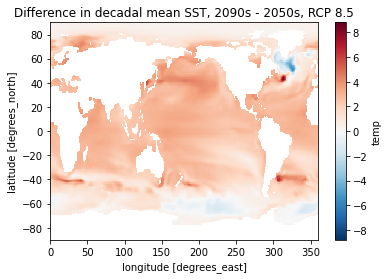

In [307]:
# Decadal mean SST for 1950's
ds_1950 = ds.temp.isel(time=slice(0,120)).mean(dim='time')

# Decadal mean SST for 2090's
ds_2090 = ds.temp.isel(time=slice(-120,None)).mean(dim='time')

# Plot difference in decadal mean under RCP 8.5
dsdiff = ds_2090 - ds_1950
dsdiff.plot()
plt.title('Difference in decadal mean SST, 2090s - 2050s, RCP 8.5')

Text(0.5, 1.0, 'Difference in decadal mean SST, 2090s - 2050s, RCP 4.5')

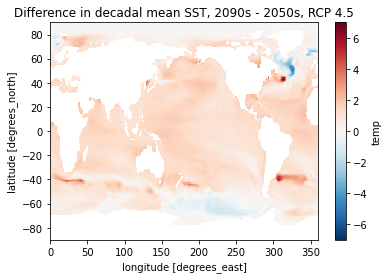

In [308]:
# Specify experiment and file name for RCP 4.5
experiment2 = 'RCP45'
filename2 = 'sst.1.rcp45.remap.2006_2100.nc'
path2 = rootdir+experiment2+'/'+filename2

# Load file using xarray
ds2 = xr.open_dataset(path2)

# Decadal mean SST for 2090's under RCP 4.5
ds2_2090 = ds2['temp'].isel(time=slice(-120,None)).mean(dim='time')

# Plot difference in decadal mean under RCP 4.5
dsdiff2 = ds2_2090 - ds_1950
dsdiff2.plot()
plt.title('Difference in decadal mean SST, 2090s - 2050s, RCP 4.5')

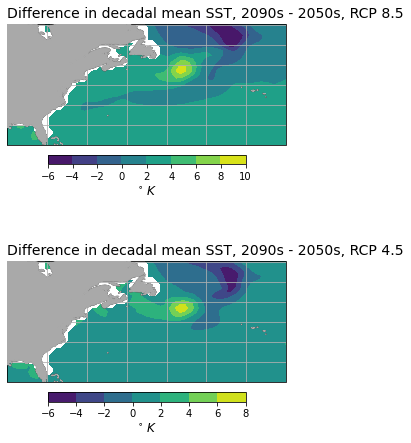

In [309]:
# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig,axs = plt.subplots(figsize=(5,8),nrows=2,subplot_kw={'projection':crs})

# Specify variables
X = ds['xt_ocean']
Y = ds['yt_ocean']
Z1 = dsdiff.squeeze()
Z2 = dsdiff2.squeeze()

# Create contour plots of SST
im1 = axs[0].contourf(X,Y,Z1,transform=crs)
im2 = axs[1].contourf(X,Y,Z2,transform=crs)

# Zoom in on North Atlantic region
axs[0].set_extent([-90,-20,25,50])
axs[1].set_extent([-90,-20,25,50])

# Add land mask, grid lines, coastlines
axs[0].add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
axs[0].gridlines()
axs[0].coastlines()

axs[1].add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
axs[1].gridlines()
axs[1].coastlines()

# Set title and colorbar
axs[0].set_title('Difference in decadal mean SST, 2090s - 2050s, RCP 8.5',fontsize=14,loc='left')
cbar = plt.colorbar(im1,ax=axs[0],orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)

axs[1].set_title('Difference in decadal mean SST, 2090s - 2050s, RCP 4.5',fontsize=14,loc='left')
cbar = plt.colorbar(im2,ax=axs[1],orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)

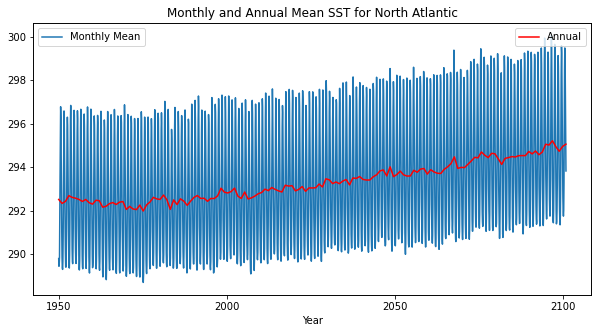

In [310]:
# Load area data
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':ds['xt_ocean'],'yt_ocean':ds['yt_ocean']})

# Shrink data to North Atlantic
dsn = ds.sel(xt_ocean=slice(270,340), yt_ocean=slice(25,50))
arean = area.sel(xt_ocean=slice(270,340), yt_ocean=slice(25,50))

# Calculate area-weighted mean SST for North Atlantic
oceanmask = np.isfinite(dsn['temp'].isel(time=0).squeeze())
area_masked = arean.where(oceanmask,np.nan)
temp_mean = (dsn['temp']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))
temp_mean_annual = temp_mean.groupby('time.year').mean()

# Plot mean SST
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(temp_mean['time'],temp_mean)
ax.set_xlabel('Year')
ax.set_title('Monthly and Annual Mean SST for North Atlantic')
plt.legend(['Monthly Mean'])

# Create second axis to account for different x values
ax2=ax.twiny()
ax2.plot(np.unique(temp_mean['time.year']),temp_mean_annual,color='red')
ax2.get_xaxis().set_visible(False)
plt.legend(['Annual'])

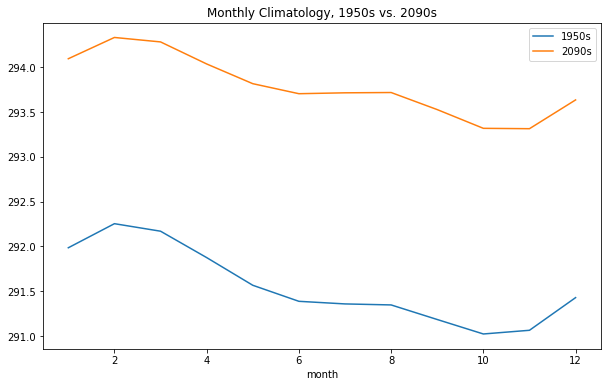

In [311]:
oceanmask = np.isfinite(ds['temp'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
gtemp_mean = (ds['temp']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))

fig, ax = plt.subplots(figsize=(10,6))

gtemp_mean_1950 = gtemp_mean.isel(time=slice(0,120))
gtemp_mean_1950.groupby('time.month').mean().plot(ax=ax)

gtemp_mean_1950 = gtemp_mean.isel(time=slice(-120,None))
gtemp_mean_1950.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Monthly Climatology, 1950s vs. 2090s')
plt.legend(['1950s','2090s'])

Text(0.5, 1.0, 'b. Hovmoller Diagram')

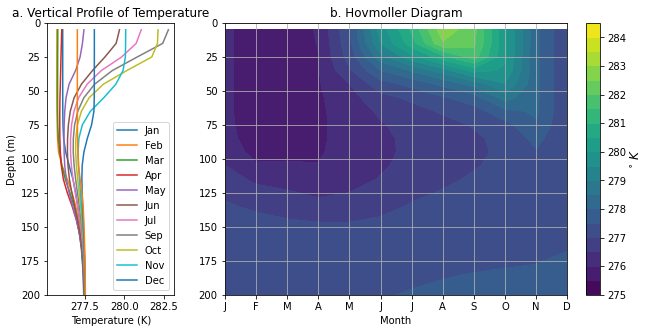

In [312]:
# Specify experiment and file name for dataset with depth dimension
filename3 = 'temp.1.rcp85.remap.1950.nc'
path3 = rootdir+experiment+'/'+filename3

# Load file using xarray
ds3 = xr.open_dataset(path3)

# Get monthly depth-temperature profile for a point in North Pacific
temps = ds3.temp.sel(longitude=180.5,latitude=50.5)

# Create file and axes
fig, axs = plt.subplots(figsize=(10,5),ncols=2,gridspec_kw={'width_ratios':[1,3]})

# Plot each month as a separate line
for month, group in temps.groupby('time.month'):
    group.plot(y='st_ocean',ax=axs[0])
    
# Adjust depth axis for better visualization
axs[0].set_ylim([200,0])

# Add labels, title, legend
axs[0].set_xlabel('Temperature (K)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('a. Vertical Profile of Temperature')
axs[0].legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Sep','Oct','Nov','Dec'])

# Set variables as month, depth, and temperature
X = temps['time.month']
Y = temps['st_ocean']
Z = temps.T

# Create contour plot of temperature
im = axs[1].contourf(X,Y,Z,np.arange(275,285,0.5))

# Adjust axis limits and tickmarks
axs[1].set_ylim([200,0])
axs[1].set_xticks(range(1,13))
axs[1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

# Add gridlines and color bar
axs[1].grid()

cbar = plt.colorbar(im,ax=axs[1],orientation='vertical',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)
# Add labels and title
axs[1].set_xlabel('Month')
axs[1].set_title('b. Hovmoller Diagram')

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'b. Zonal Average')

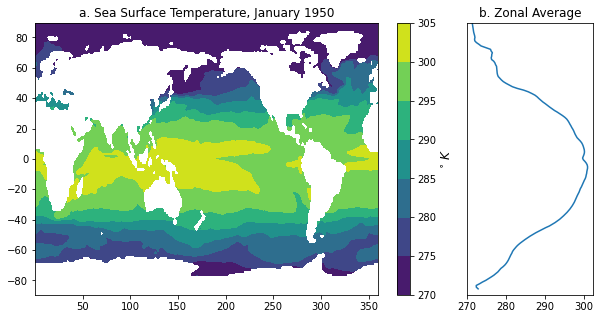

In [313]:
fig, axs = plt.subplots(figsize=(10,5),ncols=2,gridspec_kw={'width_ratios':[3,1]})

# Specify variables
X = ds['xt_ocean']
Y = ds['yt_ocean']
Z = ds['temp'].isel(time=0).squeeze()

# Create contour plot of SST
im = axs[0].contourf(X,Y,Z)

# Set title and colorbar
axs[0].set_title('a. Sea Surface Temperature, January 1950')
cbar = plt.colorbar(im,ax=axs[0],orientation='vertical',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)

ds_zonal = ds['temp'].isel(time=0).mean('xt_ocean')
axs[1].plot(ds_zonal.squeeze(),ds_zonal['yt_ocean'])
axs[1].set_ylim([-80,80])
axs[1].get_yaxis().set_visible(False)
axs[1].set_title('b. Zonal Average')